#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Задача проекта - построить модель для предсказания количества заказов.

Цель проекта - значение метрики *RMSE* на тестовой выборке меньше 48.

План проекта:

1. Загрузка данных и ресемплирование по одному часу.
2. Анализ данных.
3. Обучение моделей с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверка данных на тестовой выборке.

Целевой признак:
- `num_orders` - число заказов.

## Подготовка

In [3]:
#загрузим необходимые библиотеки

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
#Загрузим датасет
pth1 = '/datasets/taxi.csv'
pth2 = 'taxi.csv'

if os.path.exists(pth1):
    df_raw = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
    print('platform')
else:
    df_raw = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
    print('remote')

remote


In [5]:
#выполним ресемплирование по 1 часу
df_raw = df_raw.resample('1H').sum()

In [6]:
#отсортируем индексы для правильного порядка данных
df_raw.sort_index(inplace=True)

В соотвествии с задачей проекта данные загружены и выполнено ресемплирование по одному часу.

## Анализ

In [7]:
#посмотрим на данные
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
#посмотрим на порядок значений в таблице
df_raw

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Пропусков в данных нет, исследовать выбросы также не имеет смысла в рамках данной задачи.

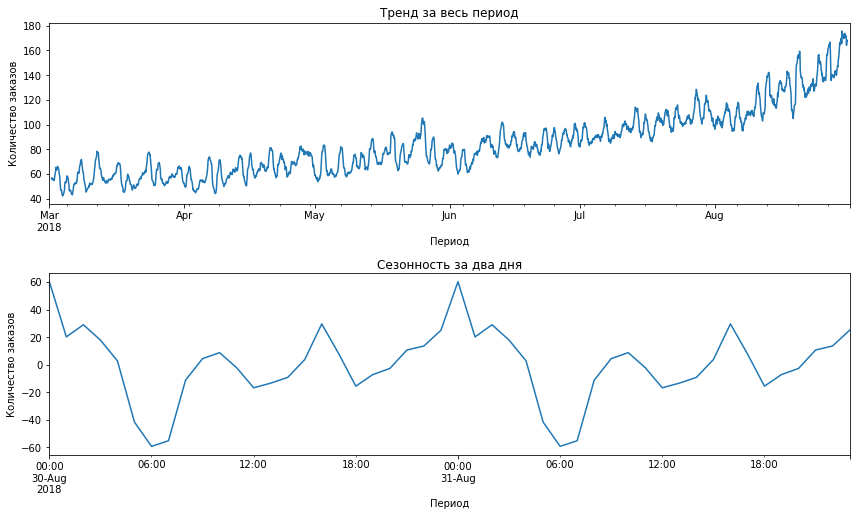

In [9]:
#построим графики тренда за весь период и сезонности за два дня
decomposed = seasonal_decompose(df_raw) 
    
plt.figure(figsize=(12,10))
    
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд за весь период')
plt.xlabel('Период')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность за два дня')
plt.xlabel('Период')
plt.ylabel('Количество заказов')

plt.tight_layout()

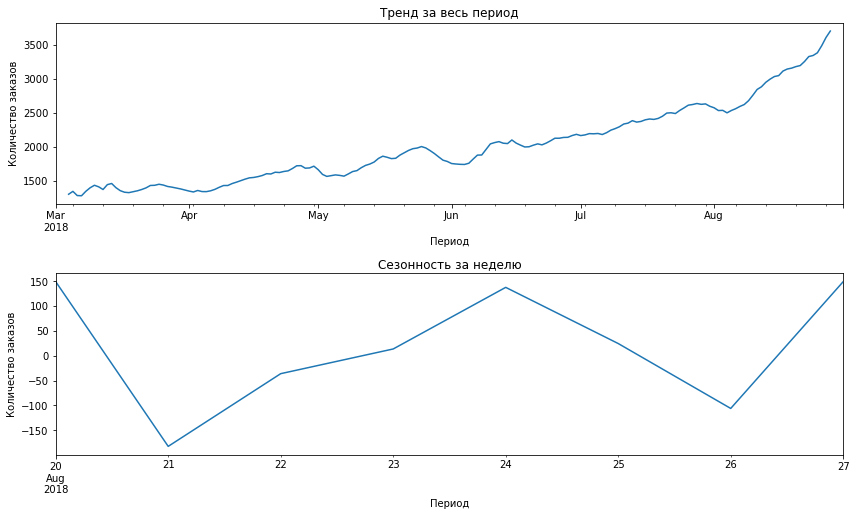

In [10]:
#построим графики тренда за весь период и сезонности за неделю

#выполним ресемплирование по 1 дню
df_day = df_raw.resample('1D').sum()

decomposed = seasonal_decompose(df_day) 
    
plt.figure(figsize=(12,10))
    
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд за весь период')
plt.xlabel('Период')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['2018-08-20':'2018-08-27'].plot(ax=plt.gca())
plt.title('Сезонность за неделю')
plt.xlabel('Период')
plt.ylabel('Количество заказов')

plt.tight_layout()

При ресемплировании данных по суткам график тренда получается более сглаженным. Кроме того, можно наблюдать выраженную сезонность по дням недели.

По графикам можно обнаружить тренд на рост заказов такси при анализе всего периода.  

По графику сезонности за два дня можно отследить закономерность спроса на такси в утреннее время, после спрос появляется вечером и в ночное время. Также наблюдается спад с 12 ночи до 6 утра. При рассмотрении периода в одну неделю можно заметить, что выскоий рост наблюдается с вечера субботы до утра воскресенья, далее спад и снова рост к концу недели.

Исходя из анализов данных показателей можно сделать вывод, что потенциально на предсказания количества заказов такси в следующий час будут оказывать влияние время суток (час заказа такси), и, возможно день недели.  

## Обучение

Далее пропишем все необходимые для подбора параметров функции.

In [11]:
#создадим новые признаки для обучения моделей
def make_features(data):
    """Функция принимает датафрейм и возвращает его
    с новыми столбцами, полученными в результате разделения индекса
    на день недели и час"""
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    return data

In [12]:
# применим функцию для создания новых признаков
df = make_features(df_raw)

In [13]:
#столбцы 'dayofweek' и 'hour' являются периодическими функциями. 
#для лучших результатов их можно закодировать, используя преобразование синуса и косинуса с соответствующим периодом.

#создадим функции для разложения значений в соответствии с тригонометрическими функциями
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [14]:
#далее выполним кодирование
df['dayofweek_sin'] = sin_transformer(7).fit_transform(df)['dayofweek']
df['dayofweek_cos'] = cos_transformer(7).fit_transform(df)['dayofweek']
df['hour_sin'] = sin_transformer(24).fit_transform(df)['hour']
df['hour_cos'] = cos_transformer(24).fit_transform(df)['hour']    

#удалим исходные столбцы
df = df.drop(['dayofweek', 'hour'], axis=1)

#посмотрим, что получилось
df

,num_orders,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
datetime,,,,,
2018-03-01 00:00:00,124,0.433884,-0.900969,0.000000,1.000000
2018-03-01 01:00:00,85,0.433884,-0.900969,0.258819,0.965926
2018-03-01 02:00:00,71,0.433884,-0.900969,0.500000,0.866025
2018-03-01 03:00:00,66,0.433884,-0.900969,0.707107,0.707107
2018-03-01 04:00:00,43,0.433884,-0.900969,0.866025,0.500000
...,...,...,...,...,...
2018-08-31 19:00:00,136,-0.433884,-0.900969,-0.965926,0.258819
2018-08-31 20:00:00,154,-0.433884,-0.900969,-0.866025,0.500000
2018-08-31 21:00:00,159,-0.433884,-0.900969,-0.707107,0.707107


In [15]:
# зададим функцию для создания новых признаков по ниаилучшим параметрам интервала и разности ряда
def make_param(data, max_lag, rolling_mean_size):
    """Функция принимает датафрейм, максимальное количество сдвигов и рамер окна.
    Возвращает датафрейм с новыми столбцами с результатами разностей между 
    соседними элементами столбца 'num_orders' в количестве max_lag
    и скользящего среднего в соотвествии с заданным интервалом. """
    
    data = data.copy()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [16]:
#зададим вычисление метрики качества rmse с помощью функции
def rmse(predict, actual):
    """Функция примает предсказания и правильные ответы. 
    Вычисляется метрика RMSE и возвращается полученное значение."""
    
    score = mean_squared_error(actual, predict, squared=False)
    
    return score

In [17]:
#создадим метрику rmse_score для дальнейших вычислений и обучения моделей
rmse_score = make_scorer(rmse, greater_is_better = False)

### Линейная модель

В ходе обучения линейной модели будет выполнен подбор оптимальных параметров. В качестве этих параметров будут выступать характеристики временного ряда, влияющие на предсказания - максимальное количество признаков с разностями соседних значений ряда и лучший интервал для вычисления скользящего среднего. Кроме того, в ходе подбора параметров данные будут поделены на тренирвочную и тестовую выборку. Эти выборки в дальнейшем будут использованы для обучения бустинговых моделей.

In [18]:
#задаим метод кросс-валидации для всех моделей с учетом особенностей временного ряда
tscv = TimeSeriesSplit(n_splits=3)

In [19]:
#проверим сначала линейную модель
model_linear = LinearRegression()

#зададим функцию для вычисления целевой метрики на основе кросс-валидации
def linear_model_cv(X, y):
    """Функция примает признаки и целевой признак.
    В ходе работы функции выполняется обучение подели линейной регрессии 
    и кросс-валидация. Значения RMSE для валидационных выборок собираются и на выход 
    подается средний показатель."""
    
    scores =[]
    cv = cross_val_score(model_linear, X, y, cv=tscv, scoring=rmse_score) 
    scores.append(cv)
    mean_rmse = abs(np.mean(scores))
    
    return mean_rmse

In [20]:
#подберем циклом наилучшие параметры интервала и разности рядов

best_result = 48
time_range = [24, 48, 72, 96, 120, 144, 169]

for max_lag in time_range:
    for rolling_mean_size in time_range:
        
        data = make_param(df, max_lag, rolling_mean_size)
        
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()
        
        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']
        
        X_test = test.drop('num_orders', axis=1)
        y_test = test['num_orders']
        
        result = linear_model_cv(X_train, y_train) 
        
        if result < best_result:
            best_result = result
            best_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
                        
print('RMSE =', best_result, 'Максимальное количество сдвигов', best_lag,',',
      'Лучший интервал', best_rolling_mean_size)

RMSE = 23.144955289726862 Максимальное количество сдвигов 169 , Лучший интервал 24


In [21]:
#в ходе работы цикла датафрейм был разбит на тренировочную и тестовую выборки
#проверим размер выборок
print('Размер тренировочных выборок')
print(X_train.shape)
print(y_train.shape)
print()
print('Размер тестовых выборок')
print(X_test.shape)
print(y_test.shape)

Размер тренировочных выборок
(3805, 174)
(3805,)

Размер тестовых выборок
(442, 174)
(442,)


### Модель LightGBM

In [22]:
#выберем диапазон параметров для варьирования один раз для всех бустинговых моделей, чтобы сравнение было корректным
param_search = {'learning_rate': [0.1, 0.3],
             'max_depth': [10, 20]}

In [23]:
#задаим постоянные параметры для модели LightGBM
params_lgb = {
    'n_estimators': 500,
    'objective': 'rmse',
    'random_state': 42}

clf = lgb.LGBMRegressor(**params_lgb)

gsearch_lgb = GridSearchCV(estimator=clf, 
                       cv=tscv, 
                       param_grid=param_search,  
                       scoring=rmse_score)

In [24]:
#обучим модель LightGBM
gsearch_lgb.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(n_estimators=500, objective='rmse',
                                     random_state=42),
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [10, 20]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [25]:
#далее посмотрим на получившийся результат
print( 'RMSE модели LightGBM:', abs(gsearch_lgb.best_score_))
print( 'Лучший набор параметров модели LightGBM:', gsearch_lgb.best_params_)

RMSE модели LightGBM: 23.850384410062787
Лучший набор параметров модели LightGBM: {'learning_rate': 0.1, 'max_depth': 20}


### Модель CatBoost

In [26]:
#задаим постоянные параметры для модели CatBoost
params_cb = {'loss_function': 'RMSE',
              'n_estimators': 300,
              'random_seed':42,
              'verbose':100}

clf = CatBoostRegressor(**params_cb)

#определим модель
gsearch_cb = GridSearchCV(estimator=clf, 
                       cv=tscv, 
                       param_grid=param_search,  
                       scoring=rmse_score)

In [27]:
#обучим модель CatBoost
gsearch_cb.fit(X_train, y_train)

0:	learn: 28.2663226	total: 401ms	remaining: 1m 59s
100:	learn: 5.1672507	total: 22.9s	remaining: 45.1s
200:	learn: 1.3518078	total: 45.5s	remaining: 22.4s
299:	learn: 0.3511404	total: 1m 7s	remaining: 0us
0:	learn: 31.4086930	total: 302ms	remaining: 1m 30s
100:	learn: 7.9623289	total: 27.5s	remaining: 54.1s
200:	learn: 3.6314430	total: 54.6s	remaining: 26.9s
299:	learn: 1.7158312	total: 1m 21s	remaining: 0us
0:	learn: 32.1693958	total: 316ms	remaining: 1m 34s
100:	learn: 10.0763576	total: 30.7s	remaining: 1m
200:	learn: 5.6408443	total: 1m 1s	remaining: 30s
299:	learn: 3.1933045	total: 1m 30s	remaining: 0us
0:	learn: 25.8833718	total: 266ms	remaining: 1m 19s
100:	learn: 0.4315766	total: 23.3s	remaining: 45.9s
200:	learn: 0.0142592	total: 46.2s	remaining: 22.8s
299:	learn: 0.0005188	total: 1m 8s	remaining: 0us
0:	learn: 28.3979945	total: 291ms	remaining: 1m 26s
100:	learn: 1.7687221	total: 27.9s	remaining: 54.9s
200:	learn: 0.2170452	total: 55.6s	remaining: 27.4s
299:	learn: 0.0302106	

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F73081BFA0>,
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [10, 20]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [28]:
#далее посмотрим на получившийся результат
print( 'RMSE модели CatBoost:', abs(gsearch_cb.best_score_))
print( 'Лучший набор параметров модели CatBoost:', gsearch_cb.best_params_)

RMSE модели CatBoost: 25.127993537072424
Лучший набор параметров модели CatBoost: {'learning_rate': 0.1, 'max_depth': 10}


## Тестирование

Линейная модель показала наилучший результат RMSE. Посмотрим, какие показатели получатся на тестовой выборке.

In [29]:
model_linear.fit(X_train, y_train) # обучим модель на тренировочной выборке
prediction_linear = model_linear.predict(X_test) # получим предсказания модели
result_linear = mean_squared_error(y_test, prediction_linear) ** 0.5  # посчитаем качество модели для предсказания

print("RMSE линейная регрессия для тестовой выборки:", round(result_linear, 4))

RMSE линейная регрессия для тестовой выборки: 34.5982


Лучший показатель RMSE среди бустинговых моделей -  LightGBM. Проверим и эту модель на тестовой выборке.

In [30]:
model_best = gsearch_lgb.best_estimator_

#далее получим предсказание и выведем метрику RMSE
prediction = model_best.predict(X_test)
result = mean_squared_error(y_test, prediction)** 0.5

print('RMSE LightGBM для тестовой выборки:',"%.4f" %result)

RMSE LightGBM для тестовой выборки: 38.6671


Показатель метрики RMSE получился меньше 48 - цель проекта достигнута.

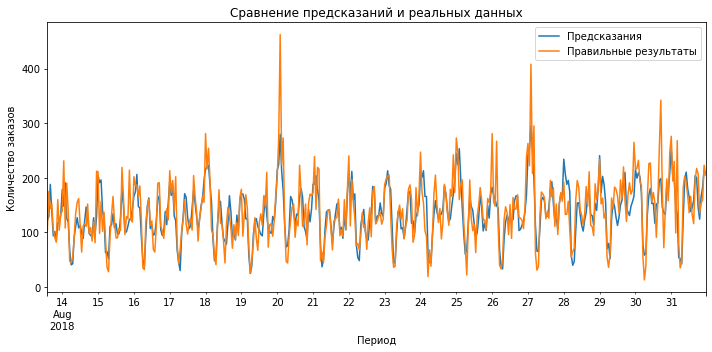

In [31]:
#посмотрим на временные ряды полученных результатов и правильных ответов за весь тестовый период

y_predicted = pd.DataFrame(prediction_linear, index=y_test.index)
y_predicted.columns = ['Предсказания']

plt.figure(figsize=(10,5))
    
y_predicted.plot(ax=plt.gca())
y_test.plot(ax=plt.gca(), label='Правильные результаты')
plt.title('Сравнение предсказаний и реальных данных')
plt.xlabel('Период')
plt.ylabel('Количество заказов')
plt.legend()
plt.tight_layout()

В целом графики похожи совпадают по направлению пиков. Однако, предсказания получились немного заниженными в сравнении с реальным количеством заказов за час. 

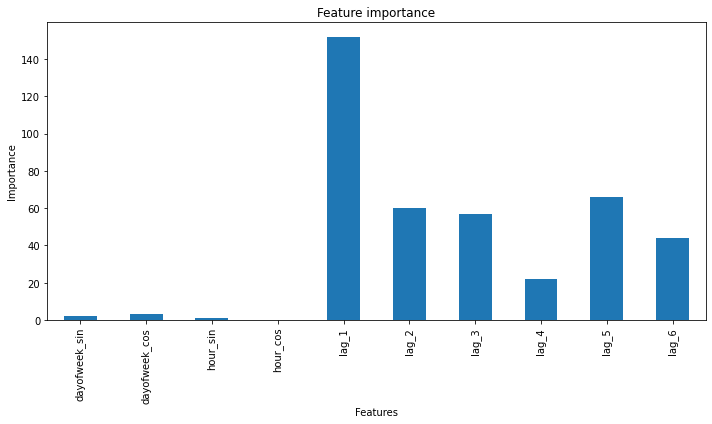

In [32]:
# посмотрим на признаки, наиболее сильно влияющие на целевую метрику для бустинговой модели
imp = pd.Series(model_best.feature_importances_,
               X_train.columns)

imp_top_10 = np.argsort(imp)[:10]

fig, ax = plt.subplots(figsize=(10,6))
imp_top_10.plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
ax.set_xlabel('Features')
fig.tight_layout()

Закодированные признаки, описывающие час дня и день недели вошли в первые 10 признаков, оказывающих влияние на целевой показатель. Наибольшее влияние оказывает признак, полученный путем смещения данных на 1 день.

## Выводы

Задача проекта выполнена - подобрана наилучшая модель CatBoost с оптимальными параметрами для предсказания количества заказов.

Цель проекта достигнута - значение метрики *RMSE* на тестовой выборке для модели Линейная регрессия меньше 48.

Выполненные этапы и результаты:

1. данные загружены и ресемплированы по одному часу;
2. выполнен анализ данных, сезонности и тренда;
3. добавлены новые признаки;
4. обучены модели и подобраны оптимальные параметры:
   - Линейная регрессия : RMSE - 23.1;
   - LightGBM : RMSE - 23.8;
   - CatBoost : RMSE - 25.1;
5. получены результаты на тестовой выборке для линейной модели: RMSE - 34.6.